In [1]:
%matplotlib inline
import numpy as np
import lmfit
import matplotlib.pyplot as plt
import pandas as pd
import corner

In [2]:
columns=['name','redshift','distance_mod','DM_err','SN_prob']
rawdat=pd.read_csv('SCPUnion2.1_mu_vs_z.txt', sep='\s',names=columns, header=5, engine='python')

In [3]:
data=np.sort(rawdat.T, axis=0)
print(data[2].shape)


(579,)


In [4]:
rawdat['redshift']

0      0.050043
1      0.052926
2      0.070086
3      0.062668
4      0.087589
5      0.078577
6      0.017227
7      0.042233
8      0.045295
9      0.036480
10     0.019599
11     0.100915
12     0.027342
13     0.074605
14     0.026489
15     0.049922
16     0.030604
17     0.016346
18     0.015436
19     0.030529
20     0.024525
21     0.023953
22     0.026038
23     0.048948
24     0.024314
25     0.015166
26     0.035720
27     0.048818
28     0.021980
29     0.124400
         ...   
549    0.216000
550    0.735000
551    1.140000
552    1.307000
553    1.265000
554    0.670000
555    0.640000
556    1.340000
557    0.840000
558    0.935000
559    0.953000
560    1.124000
561    0.552000
562    0.671000
563    0.511000
564    1.030000
565    1.192000
566    1.092000
567    0.974000
568    1.110000
569    1.350000
570    0.850000
571    1.241000
572    1.414000
573    1.188000
574    1.017000
575    1.315000
576    0.821000
577    1.215000
578    0.623000
Name: redshift, Length: 

In [5]:
rawdat.redshift[100]

0.0229

In [6]:
zs = rawdat.redshift
mm = rawdat.distance_mod
dm = rawdat.DM_err

In [7]:
def mzz(H0,m0,OmM,OmL,z):
    Omk = 1.-OmM-OmL
    OI = OmM*(1+zz)**3+Omk*(1+zz)**2+OmL
    #print "IOmM,IOmL,OmM,OmL,Omk = ",IOmM,IOmL,OmM,OmL,Omk
    # protect against sqrt(-1). Else, no Big Bang
    OI[OI<0.001] = 0.001
    # comoving distance
    dCz = np.cumsum(1./np.sqrt(OI))*dz
    # curvature cases, for transverse comoving distance:
    if (Omk < 0.):
        dMz = np.sin(np.sqrt(-Omk)*dCz)/np.sqrt(-Omk)
        dMz[dMz < 0.0001] = 0.0001  # what if this goes negative?
    elif (Omk > 0.):
        dMz = np.sinh(np.sqrt(Omk)*dCz)/np.sqrt(Omk)
    else:
        dMz = dCz
    # convert luminosity distance into a magnitude: theory prediction, smooth curve
    mc = m0 + 5.0*np.log10(dH*dMz*(1+zz))
    ms = np.interp(z,zz,mc)
    return ms

In [8]:
# vector of redshifts for smooth curves
dz = 0.001
zz = np.arange(dz,2.0,dz)

# estimate H0 and m0 from low-z SN:
c = 299792.   # km/s
i1 = zs<0.05
H0 = (c*1.e6/10.**(mm[i1]/5.+1)*zs[i1]).mean()
# horizon distance
dH = c/H0
ms = 5.0*np.log10(dH*zs)
# only use the nearby data with linear Hubble to determine m0:
m0 = np.sum((mm[i1]-ms[i1])/dm[i1]**2)/np.sum(1./dm[i1]**2)

In [9]:
p = lmfit.Parameters()
p.add_many(('OmM',0.3),('OmL',0.7),('H0',70.0))

def residual(p):
    v = p.valuesdict()
    return (mzz(H0,m0,v['OmM'],v['OmL'],zs)-mm)/dm

In [10]:
mi = lmfit.minimize(residual, p, method='nelder', nan_policy='omit')

In [11]:
res=lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1000, thin=1, params=mi.params)

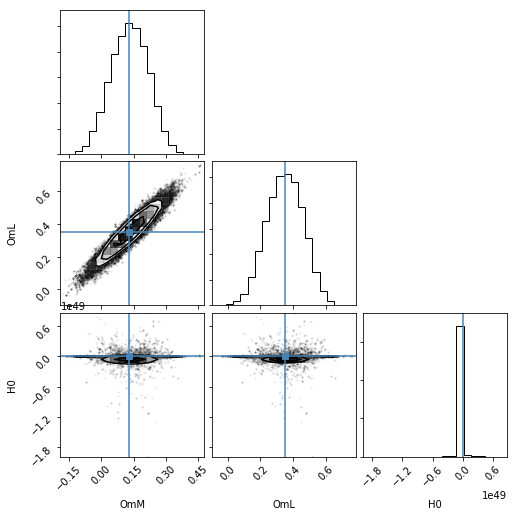

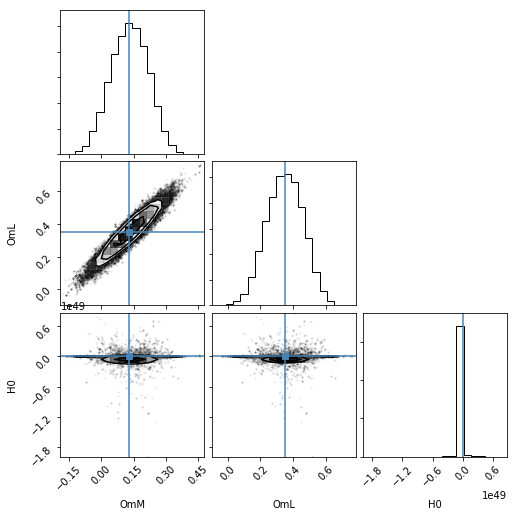

In [12]:
corner.corner(res.flatchain,labels=mi.var_names, truths=list(mi.params.valuesdict().values()))
   